## Testing on base model V17

#### Train + Val - skate_satila and skate_city
#### Test - skate_without_video


In [1]:
# import statements

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import Series

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from random import shuffle

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE


/Users/nickeylawrence/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Training data

# Read the Gear2 data
Gear2Files = ['./skate_satila/Gear2_1.csv', './skate_satila/Gear2_2.csv', './skate_city/gear2.csv']

X_Gear2=[0] * len(Gear2Files)
Y_Gear2=[0] * len(Gear2Files)
for index,file in enumerate(Gear2Files):
    X_Gear2[index] = pd.read_csv(file);
    Y_Gear2[index] = pd.DataFrame(data= np.full((X_Gear2[index].shape[0],1), 2));
    X_Gear2[index] = X_Gear2[index].assign(Gear=Y_Gear2[index].values);

# Read the Gear3 data
Gear3Files = ['./skate_satila/Gear3_1.csv', './skate_satila/Gear3_2.csv', './skate_city/gear3.csv']

X_Gear3=[0] * len(Gear3Files)
Y_Gear3=[0] * len(Gear3Files)
for index,file in enumerate(Gear3Files):
    X_Gear3[index] = pd.read_csv(file);
    Y_Gear3[index] = pd.DataFrame(data= np.full((X_Gear3[index].shape[0],1), 3));
    X_Gear3[index] = X_Gear3[index].assign(Gear=Y_Gear3[index].values);

# Read the Gear4 data
Gear4Files = ['./skate_satila/Gear4_1.csv', './skate_city/gear4.csv']

X_Gear4=[0] * len(Gear4Files)
Y_Gear4=[0] * len(Gear4Files)
for index,file in enumerate(Gear4Files):
    X_Gear4[index] = pd.read_csv(file);
    Y_Gear4[index] = pd.DataFrame(data= np.full((X_Gear4[index].shape[0],1), 4));
    X_Gear4[index] = X_Gear4[index].assign(Gear=Y_Gear4[index].values);

# Read the Gear 5 data
Gear5Files = ['./skate_satila/Double_1.csv', './skate_satila/Double_2.csv', './skate_satila/Double_3.csv',
                  './skate_city/double.csv']

X_Gear5=[0] * len(Gear5Files)
Y_Gear5=[0] * len(Gear5Files)
for index,file in enumerate(Gear5Files):
    X_Gear5[index] = pd.read_csv(file);
    Y_Gear5[index] = pd.DataFrame(data= np.full((X_Gear5[index].shape[0],1), 5));
    X_Gear5[index] = X_Gear5[index].assign(Gear=Y_Gear5[index].values);
    

In [3]:
# Implement moving average for a window size of 3, and split the segments such that each has 750 time-steps, 
# for training data

limit = 750
features = list(X_Gear2[0].columns);
scaledFeatures = [item for item in features if item not in ['t','Gear']]

XGear=[]
for index in range(len(X_Gear2)):
    dataG2 = X_Gear2[index];
    x = dataG2[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear2[index][scaledFeatures] = rolling_mean;
    dataG2 = X_Gear2[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG2)/limit);
    XGear += [dataG2[t*limit:t*limit + limit] for t in range(gearRange)];  
    
for index in range(len(X_Gear3)):
    dataG3 = X_Gear3[index];
    x = dataG3[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear3[index][scaledFeatures] = rolling_mean;
    dataG3 = X_Gear3[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG3)/limit);
    XGear += [dataG3[t*limit:t*limit + limit] for t in range(gearRange)];  
    
for index in range(len(X_Gear4)):
    dataG4 = X_Gear4[index];
    x = dataG4[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear4[index][scaledFeatures] = rolling_mean;
    dataG4 = X_Gear4[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG4)/limit);
    XGear += [dataG4[t*limit:t*limit + limit] for t in range(gearRange)];  
    
    
for index in range(len(X_Gear5)):
    dataG5 = X_Gear5[index];
    x = dataG5[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear5[index][scaledFeatures] = rolling_mean;
    dataG5 = X_Gear5[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG5)/limit);
    XGear += [dataG5[t*limit:t*limit + limit] for t in range(gearRange)];  
    
    

In [4]:
## Test data

testGear2Files = ['./skate_without_video/Gear2/segment2.csv', './skate_without_video/Gear2/segment3.csv','./skate_without_video/Gear2/segment4.csv',
              './skate_without_video/Gear2/segment5.csv','./skate_without_video/Gear2/segment6.csv'
            ]
testGear3Files = ['./skate_without_video/Gear3/segment1.csv', './skate_without_video/Gear3/segment2.csv','./skate_without_video/Gear3/segment3.csv',
              './skate_without_video/Gear3/segment4.csv','./skate_without_video/Gear3/segment5.csv', './skate_without_video/Gear3/segment6.csv']


testGear4Files = ['./skate_without_video/Gear4/segment2.csv','./skate_without_video/Gear4/segment3.csv','./skate_without_video/Gear4/segment4.csv',
              './skate_without_video/Gear4/segment5.csv', './skate_without_video/Gear4/segment6a.csv','./skate_without_video/Gear4/segment6b.csv']


testDoubleFiles = ['./skate_without_video/Double/segment1.csv','./skate_without_video/Double/segment2.csv','./skate_without_video/Double/segment3.csv',
              './skate_without_video/Double/segment4.csv', './skate_without_video/Double/segment5.csv','./skate_without_video/Double/segment7.csv']



# Read the Gear 2 data
testX_Gear2=[0] * len(testGear2Files)
testY_Gear2=[0] * len(testGear2Files)
for index,file in enumerate(testGear2Files):
    testX_Gear2[index] = pd.read_csv(file);
    testY_Gear2[index] = pd.DataFrame(data= np.full((testX_Gear2[index].shape[0],1), 2));
    testX_Gear2[index] = testX_Gear2[index].assign(Gear=testY_Gear2[index].values);


# Read the Gear 3 data
testX_Gear3=[0] * len(testGear3Files)
testY_Gear3=[0] * len(testGear3Files)
for index,file in enumerate(testGear3Files):
    testX_Gear3[index] = pd.read_csv(file);
    testY_Gear3[index] = pd.DataFrame(data= np.full((testX_Gear3[index].shape[0],1), 3));
    testX_Gear3[index] = testX_Gear3[index].assign(Gear=testY_Gear3[index].values);


# Read the Gear 4 data
testX_Gear4=[0] * len(testGear4Files)
testY_Gear4=[0] * len(testGear4Files)
for index,file in enumerate(testGear4Files):
    testX_Gear4[index] = pd.read_csv(file);
    testY_Gear4[index] = pd.DataFrame(data= np.full((testX_Gear4[index].shape[0],1), 4));
    testX_Gear4[index] = testX_Gear4[index].assign(Gear=testY_Gear4[index].values);


# Read the Gear Double data
testX_GearD=[0] * len(testDoubleFiles)
testY_GearD=[0] * len(testDoubleFiles)
for index,file in enumerate(testDoubleFiles):
    testX_GearD[index] = pd.read_csv(file);
    testY_GearD[index] = pd.DataFrame(data= np.full((testX_GearD[index].shape[0],1), 5));
    testX_GearD[index] = testX_GearD[index].assign(Gear=testY_GearD[index].values);


limit = 750

testXGear=[]
for index, dataG2 in enumerate(testX_Gear2):
    gearRange = math.ceil(len(dataG2)/limit)
    testXGear += [dataG2[t*limit:t*limit + limit] for t in range(gearRange)]

for index, dataG3 in enumerate(testX_Gear3):
    gearRange = math.ceil(len(dataG3)/limit)
    testXGear += [dataG3[t*limit:t*limit + limit] for t in range(gearRange)]

for index, dataG4 in enumerate(testX_Gear4):
    gearRange = math.ceil(len(dataG4)/limit)
    testXGear += [dataG4[t*limit:t*limit + limit] for t in range(gearRange)]
    
for index, dataGD in enumerate(testX_GearD):
    gearRange = math.ceil(len(dataGD)/limit)
    testXGear += [dataGD[t*limit:t*limit + limit] for t in range(gearRange)]
    

In [5]:
# training data
X = XGear[:] # Copy words
shuffle(X) 

X = pd.concat(X);

data = pd.DataFrame(X);

data.reset_index(inplace = True, drop = True)
for i in range(len(data)):
    data.loc[i,'t'] = i*0.02

In [6]:
# test data
testX = testXGear[:] 
shuffle(testX)

testX = pd.concat(testX);

testData = pd.DataFrame(testX);

testData.reset_index(inplace = True, drop = True)
for i in range(len(testData)):
    testData.loc[i,'t'] = i*0.02

In [7]:
# Normalisation
# Feature normalization
# Normalize Time Series Data
# Source : https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

# Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
# useful when your time series data has input values with differing scales.

# Normalize training data
features = list(data.columns);
scaledFeatures = [item for item in features if item not in ['t','Gear']]

for i in range(len(scaledFeatures)):
    feature = scaledFeatures[i];
    print('Scaling feature : ', scaledFeatures[i])
    values = X[feature].values.reshape(-1,1);
    values = values.astype('float32');
    scaler = MinMaxScaler(feature_range = (0,1));
    scaled_f = scaler.fit_transform(values);
    X[feature] = scaled_f;
    
    
# Normalize test data 
testfeatures = list(testData.columns);
scaledTestFeatures = [item for item in testfeatures if item not in ['t','Gear']]

for i in range(len(scaledTestFeatures)):
    feature = scaledTestFeatures[i];
    print('Scaling feature : ', scaledTestFeatures[i])
    values2 = testX[feature].values.reshape(-1,1);
    values2 = values2.astype('float32');
    scaler = MinMaxScaler(feature_range = (0,1));
    scaled_f = scaler.fit_transform(values2);
    testX[feature] = scaled_f;



Scaling feature :  fL
Scaling feature :  thL
Scaling feature :  w1L
Scaling feature :  w2L
Scaling feature :  w3L
Scaling feature :  a1L
Scaling feature :  a2L
Scaling feature :  a3L
Scaling feature :  fR
Scaling feature :  thR
Scaling feature :  w1R
Scaling feature :  w2R
Scaling feature :  w3R
Scaling feature :  a1R
Scaling feature :  a2R
Scaling feature :  a3R
Scaling feature :  x
Scaling feature :  y
Scaling feature :  z
Scaling feature :  v
Scaling feature :  fL
Scaling feature :  thL
Scaling feature :  w1L
Scaling feature :  w2L
Scaling feature :  w3L
Scaling feature :  a1L
Scaling feature :  a2L
Scaling feature :  a3L
Scaling feature :  fR
Scaling feature :  thR
Scaling feature :  w1R
Scaling feature :  w2R
Scaling feature :  w3R
Scaling feature :  a1R
Scaling feature :  a2R
Scaling feature :  a3R
Scaling feature :  x
Scaling feature :  y
Scaling feature :  v
Scaling feature :  vdir


In [8]:
# Create one-hot Y vectors
features.remove('Gear')
features.remove('x')
features.remove('y')
features.remove('z')

X = data[features]
Y = data['Gear']


In [9]:
testfeatures = list(testData.columns);
testfeatures.remove('Gear')
testfeatures.remove('x')
testfeatures.remove('y')
testfeatures.remove('v')

testX = testData[testfeatures]
testY = testData['Gear']


In [10]:
# Create one-hot Y vectors
Y_onehot = pd.get_dummies(Y).values;
testY_onehot = pd.get_dummies(testY).values;


In [11]:
X = np.array(X)
Y = np.array(Y_onehot)

testX = np.array(testX)
testY = np.array(testY_onehot)


In [12]:
# Create training, validation data and test data
timesteps = 1
XNew = X.reshape(X.shape[0],timesteps,18)
YNew = Y.reshape(Y.shape[0],timesteps,4)

# trainX, testX, trainY, testY = train_test_split(XNew, YNew, test_size=0.2);
# trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2);

trainX, valX, trainY, valY = train_test_split(XNew, YNew, test_size=0.2);
testX = testX.reshape(testX.shape[0],timesteps,18)
testY = testY.reshape(testY.shape[0],timesteps,4)



In [14]:
# design and fit our LSTM network

model = Sequential();
model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, 17)));
model.add(Dense(4, activation = 'softmax'));
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history = model.fit(trainX[:,:,1:], trainY, epochs=50, batch_size=100, validation_data=(valX[:,:,1:],valY))


Train on 245744 samples, validate on 61437 samples
Epoch 1/50
245744/245744 [==============================] - 123s 501us/step - loss: 1.0566 - categorical_accuracy: 0.5656 - val_loss: 0.9882 - val_categorical_accuracy: 0.6126
Epoch 2/50
245744/245744 [==============================] - 111s 451us/step - loss: 0.9486 - categorical_accuracy: 0.6272 - val_loss: 0.9155 - val_categorical_accuracy: 0.6494
Epoch 3/50
245744/245744 [==============================] - 116s 473us/step - loss: 0.8719 - categorical_accuracy: 0.6611 - val_loss: 0.8373 - val_categorical_accuracy: 0.6661
Epoch 4/50
245744/245744 [==============================] - 154s 629us/step - loss: 0.8040 - categorical_accuracy: 0.6870 - val_loss: 0.7945 - val_categorical_accuracy: 0.6857
Epoch 5/50
245744/245744 [==============================] - 142s 578us/step - loss: 0.7469 - categorical_accuracy: 0.7109 - val_loss: 0.7271 - val_categorical_accuracy: 0.7200
Epoch 6/50
245744/245744 [==============================] - 167s 678u

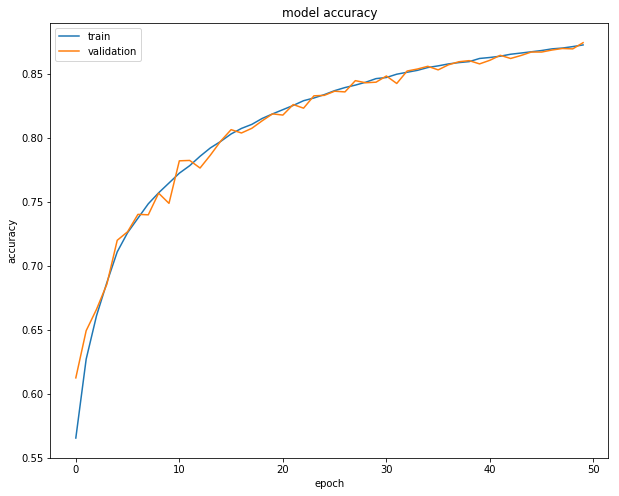

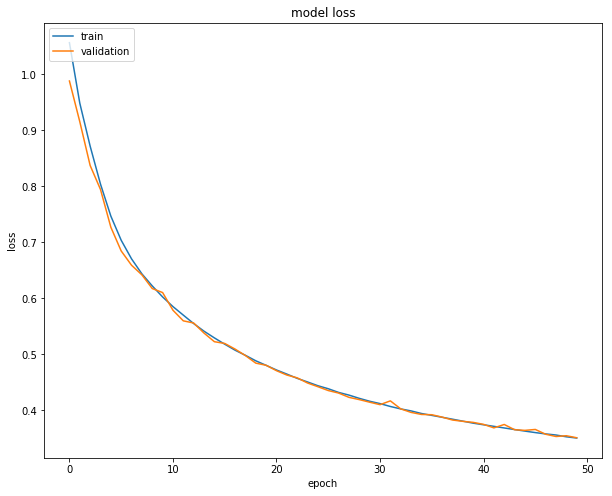

In [15]:
# summarize history for accuracy
plt.figure(0,figsize=(10, 8))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(0,figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
# Evaluate
predictions = model.predict_classes(testX[:,:,1:])

In [17]:
scores = model.evaluate(testX[:,:,1:], testY, verbose=2)
print(scores)

[5.638373307265011, 0.2652023121387283]


In [18]:
timeTest = np.array(testX[:,:,0])
forceLeftTest = np.array(testX[:,:,1])
forceRightTest = np.array(testX[:,:,9])
predTest = np.array(predictions+2)
realTest = np.array(np.argmax(testY, axis=2)+2)
result = np.concatenate((timeTest,forceLeftTest, forceRightTest, predTest, realTest), axis=1)

In [19]:
ind=np.argsort(result[:,0])
result2 = result[ind]

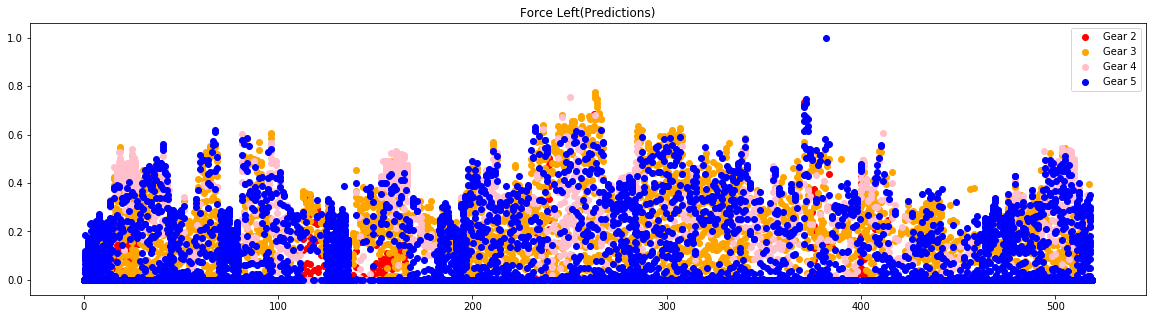

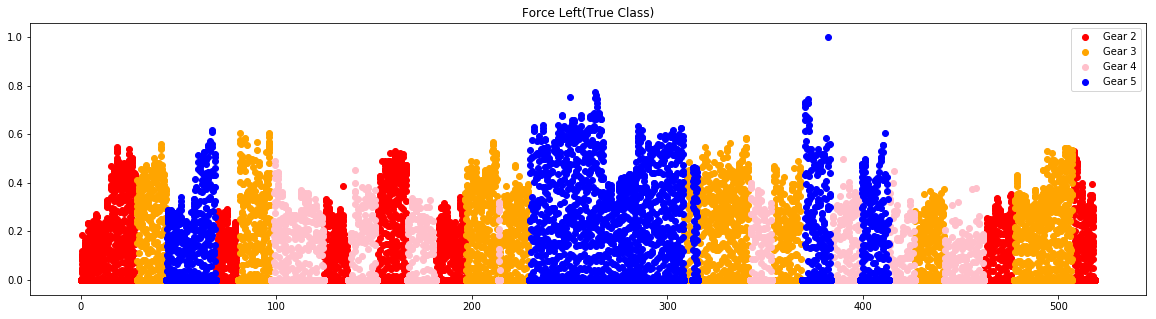

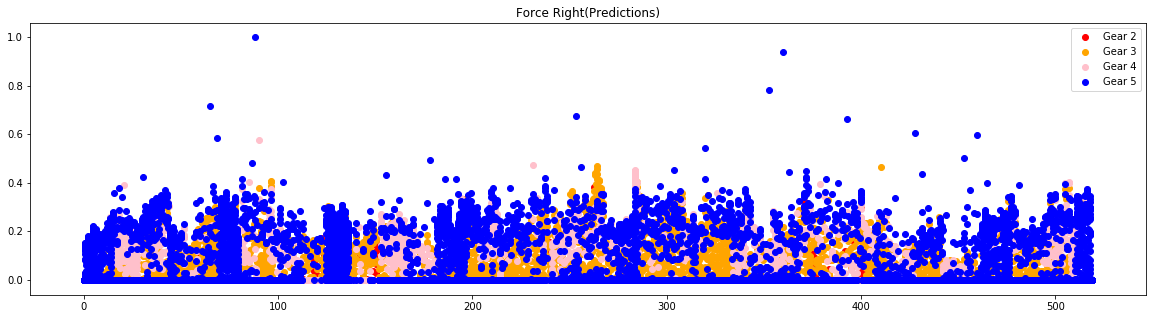

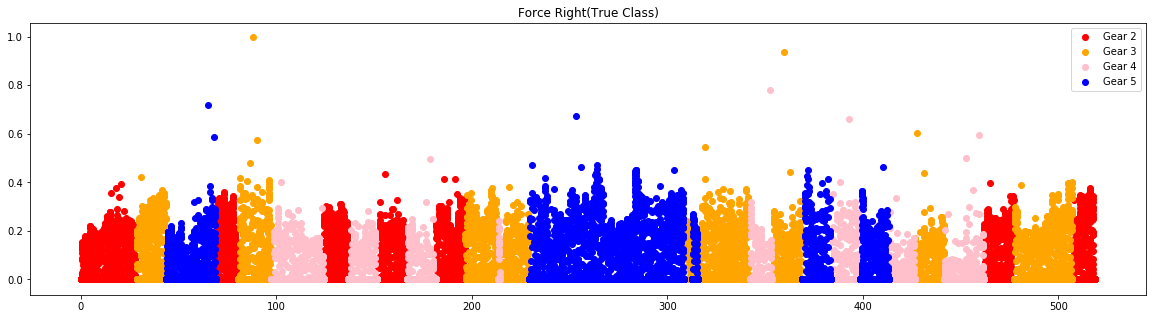

In [20]:
plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Left(Predictions)')
for i in range(2,6):
    classResult = result[result[:,3]==i]
    plt.scatter(classResult[:,0],classResult[:,1],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Left(True Class)')
for i in range(2,6):
    classRealResult = result[result[:,4]==i]
    plt.scatter(classRealResult[:,0],classRealResult[:,1],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
plt.title('Force Right(Predictions)')
for i in range(2,6):
    classResult = result[result[:,3]==i]
    plt.scatter(classResult[:,0],classResult[:,2],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Right(True Class)')
for i in range(2,6):
    classRealResult = result[result[:,4]==i]
    plt.scatter(classRealResult[:,0],classRealResult[:,2],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()


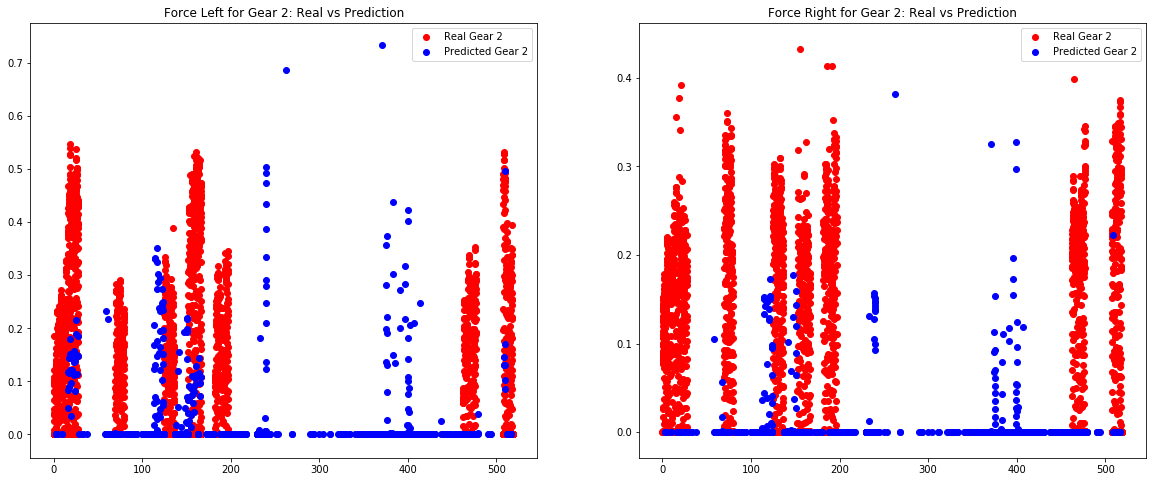

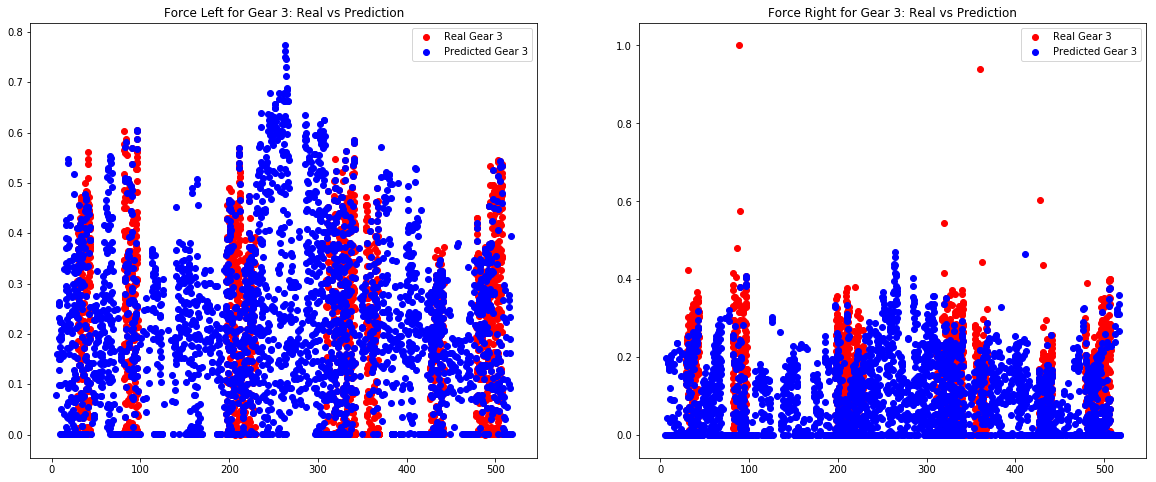

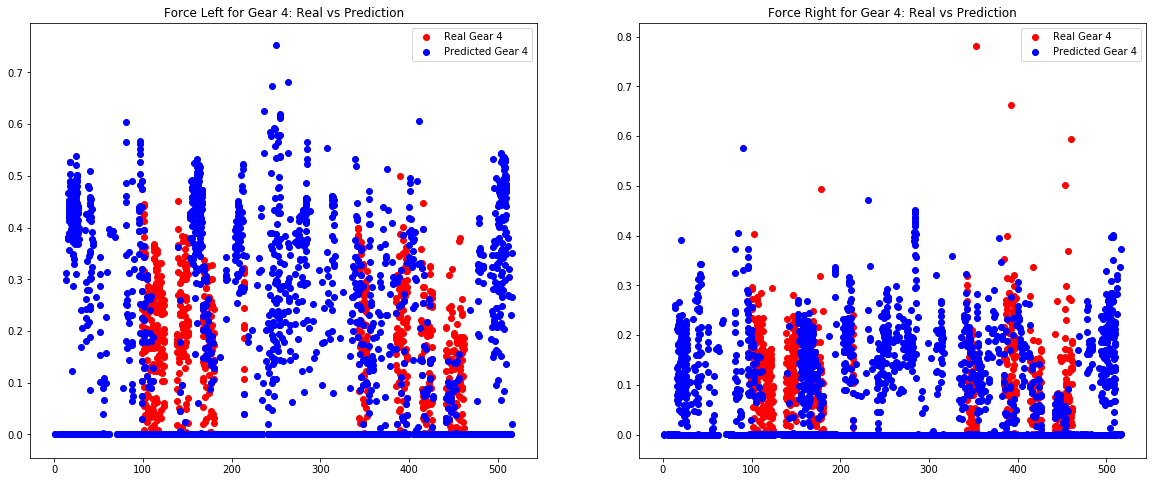

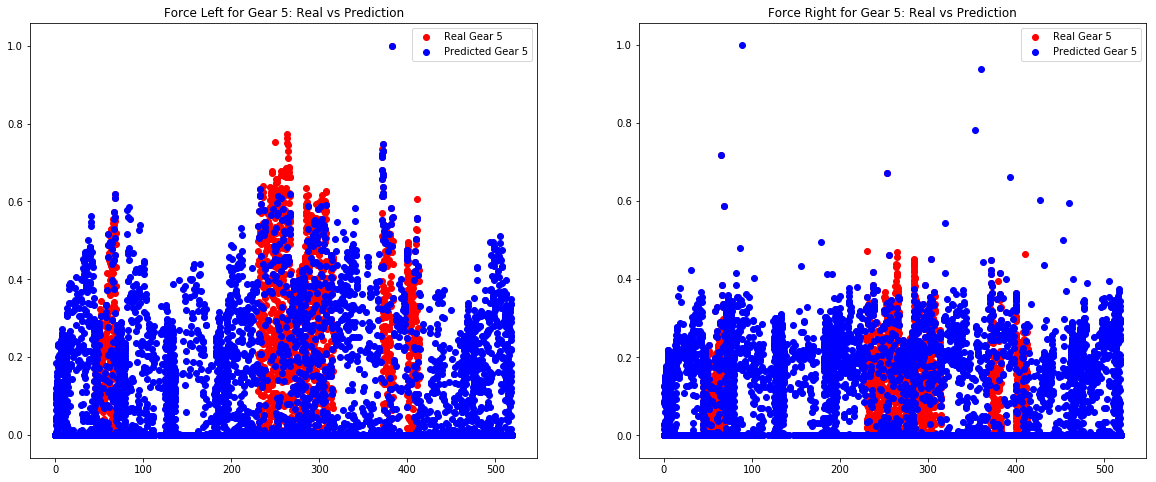

In [21]:
for i in range(2,6):
    classPredResult = result[result[:,3]==i]
    classRealResult = result[result[:,4]==i]
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))
    
    ax1.set_title('Force Left for Gear '+str(i) +': Real vs Prediction') 
    ax1.scatter(classRealResult[:,0],classRealResult[:,1],c ='red',label='Real Gear ' + str(i))
    ax1.scatter(classPredResult[:,0],classPredResult[:,1],c ='blue',label='Predicted Gear ' + str(i))
    ax1.legend(loc="upper right")
    
    ax2.set_title('Force Right for Gear '+str(i) +': Real vs Prediction') 
    ax2.scatter(classRealResult[:,0],classRealResult[:,2],c ='red',label='Real Gear ' + str(i))
    ax2.scatter(classPredResult[:,0],classPredResult[:,2],c ='blue',label='Predicted Gear ' + str(i))
    ax2.legend(loc="upper right")
plt.show()    